# Heat equation

## imports

In [1]:
import numpy as np
import pandas as pd
import scipy

In [2]:
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm_notebook
from IPython.display import HTML

## initialization

<img src="task2.png">

In [3]:
problem = input("Which type of problem do you need? '1' or '2' \n")

Which type of problem do you need? '1' or '2' 
2


In [50]:
X_max = 50
Y_max = 50
X_min = Y_min = 0

NUMBER_X = 100
NUMBER_Y = 100
DELTA = 10

In [51]:
def calculate_all(NUMBER_X, NUMBER_Y):
    X_RANGE = np.linspace(X_min, X_max, NUMBER_X)
    Y_RANGE = np.linspace(Y_min, Y_max, NUMBER_Y)

    X_STEP = X_RANGE[1] - X_RANGE[0]
    Y_STEP = Y_RANGE[1] - Y_RANGE[0]

    X, Y = np.meshgrid(X_RANGE, Y_RANGE, indexing='ij')

    Y_RATIO = (Y - Y_min) / (Y_max - Y_min)
    X_RATIO = (X - X_min) / (X_max - X_min)

    U = np.zeros_like(X)
    U_coef = np.zeros_like(X)

    source = np.zeros_like(X)
    source_coef = np.zeros_like(X)
    
    alpha = np.zeros_like(X_RANGE)
    beta = np.zeros_like(X_RANGE)

    source = np.exp( -1 * (
            (X - (X_max / 2)) ** 2 + 
            (Y - (Y_max / 2)) ** 2) / (DELTA ** 2))
    
    if problem == '1':
        U_LOWER = 0         # lower bound
        U_UPPER = 0         # upper bound
        Q_LEFT  = 0         # left bound
        U_RIGHT = 0         # right bound

        alpha[1] = 1
        beta[1] = Q_LEFT
        U[-1, :] = U_RIGHT

    elif problem == '2':
        U_LOWER = 0         # lower bound
        U_UPPER = 0         # upper bound
        U_LEFT  = 0         # left bound
        U_RIGHT = 0         # right bound

        U[-1, :] = U_RIGHT
        U[0, :]  = U_LEFT
        U[:, -1] = U_UPPER
        U[:, 0]  = U_LOWER

    else:
        raise ValueError('wrong problem type')
    
    for m in range(1, NUMBER_Y - 1):
        source_coef[:, m] = 2 / NUMBER_Y * (source * np.sin(np.pi * m * Y_RATIO))[:,1:-1].sum(axis=1)

    lambdas = 4 * np.square(np.sin(np.pi * Y_RATIO[0, :] / 2))
    
    if problem == '1':
        for j in tqdm.tnrange(0, NUMBER_Y - 1):
            alpha, beta = calculate_coefficients(alpha, beta, source_coef[:, j+1], lambdas[j+1], X_STEP, Y_STEP)

            for i in reversed(range(0, NUMBER_X - 1)):
                U_coef[i, j+1] = alpha[i+1] * U_coef[i+1, j+1] + beta[i+1]

    elif problem == '2':
        phi = np.zeros_like(source_coef)
        v = np.zeros_like(source_coef)
        gammas = 4 * np.square(np.sin(np.pi * X_RATIO[:,0] / 2))

        G, L = np.meshgrid(gammas, lambdas, indexing='ij')

        for l in range(1, NUMBER_X - 1):
            phi[l, :] = 2 / NUMBER_X * (source_coef * np.sin(np.pi * l * X_RATIO))[1:-1, :].sum(axis=0)

        with np.errstate(divide='ignore', invalid='ignore'):
            v = phi / (G / (X_STEP ** 2) + L / (Y_STEP ** 2))
        v[np.isnan(v)] = 0

        for i in range(1, NUMBER_X - 1):
            U_coef[i, :] = (v * np.sin(np.pi * i * X_RATIO))[1:-1, :].sum(axis=0)

    else:
        raise ValueError('wrong problem type')
        
    for j in range(0, NUMBER_Y):
        U[:, j] = (U_coef * np.sin(np.pi * j * Y_RATIO))[:,1:-1].sum(axis=1)
        
    return U
    
def calculate_coefficients(alpha, beta, s, lam, X_STEP, Y_STEP):
    a = b = 1 / (X_STEP ** 2)
    c = 2 / (X_STEP ** 2) + lam / (Y_STEP ** 2)
    d = s
    
    for i in range(1, len(s) - 1):
        alpha[i+1] = b / (c - alpha[i] * a)
        beta [i+1] = (a * beta[i] + d[i]) / (c - alpha[i] * a)

    return alpha, beta


def heatmap2d(arr: np.ndarray, interpolation=None):
    plt.imshow(arr.T, cmap='hot', interpolation=interpolation)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Temperature map')
    ax = plt.gca()
    ax.invert_yaxis()

## boundary conditions

## main procedure

In [52]:
U = calculate_all(NUMBER_X, NUMBER_Y)

## vizualization

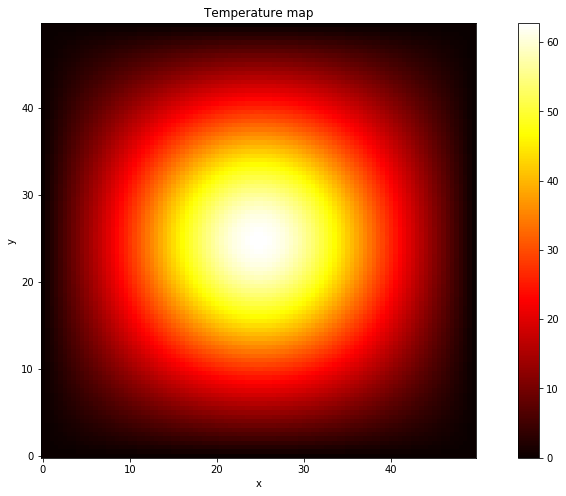

In [53]:
fig, ax = plt.subplots(figsize=(15, 8))
heatmap2d(U)

ticks = ax.get_xticks()
ax.set_xticklabels([str(int(X_min + x * (X_max - X_min) // (NUMBER_X)))
                    for x in ticks])

ticks = ax.get_yticks()
ax.set_yticklabels([str(int(Y_min + x * (Y_max - Y_min) // (NUMBER_Y)))
                    for x in ticks]);

## accuracy

In [54]:
U_result = np.repeat(np.zeros_like(U)[np.newaxis, :, :], 3, axis=0)
U_clean = np.zeros_like(U)
for h in [1,2,4]:
    number_x = NUMBER_X * h
    number_y = NUMBER_Y * h
    U = calculate_all(number_x, number_y)
    U_result[int(np.log2(h)), :, :] = U[::h, ::h]

In [55]:
L = (np.abs(U_result[0] - U_result[1])).max() / (np.abs(U_result[2] - U_result[1])).max()
np.log2(L)

0.9926746709538484

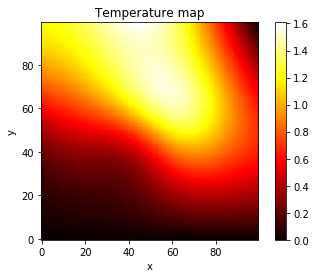

In [25]:
heatmap2d(np.abs(U_result[0] - U_result[1]))